In [1]:
import threading
import multiprocessing
import logging
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.layers as kl
import tensorflow.keras.losses as kls
import tensorflow.keras.optimizers as ko
from tqdm.notebook import tqdm
%matplotlib inline

print("TensorFlow Ver: ", tf.__version__)

TensorFlow Ver:  2.1.0


In [2]:
seed = 1234
tf.random.set_seed(seed)
np.random.seed(seed)

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [4]:
# Eager by default!
print("Eager Execution:", tf.executing_eagerly())
print("1 + 2 + 3 + 4 + 5 =", tf.reduce_sum([1, 2, 3, 4, 5]))

Eager Execution: True
1 + 2 + 3 + 4 + 5 = tf.Tensor(15, shape=(), dtype=int32)


In [5]:
class dependent_bandit():
    def __init__(self, difficulty):
        self.num_actions = 2
        self.n_timesteps = 100
        self.difficulty = difficulty
        self.reset()
        
    def set_restless_prob(self):
        self.bandit = np.array([self.restless_list[self.timestep],1 - self.restless_list[self.timestep]])
        
    def reset(self):
        self.timestep = 0
        if self.difficulty == 'restless': 
            variance = np.random.uniform(0,.5)
            self.restless_list = np.cumsum(np.random.uniform(-variance,variance,(150,1)))
            self.restless_list = (self.restless_list - np.min(self.restless_list)) / (np.max(self.restless_list - np.min(self.restless_list))) 
            self.set_restless_prob()
        if self.difficulty == 'easy': 
            bandit_prob = np.random.choice([0.9,0.1])
        if self.difficulty == 'trivial': 
            bandit_prob = np.random.choice([1.0,0.0])
        if self.difficulty == 'medium': 
            bandit_prob = np.random.choice([0.75,0.25])
        if self.difficulty == 'hard': 
            bandit_prob = np.random.choice([0.6,0.4])
        if self.difficulty == 'uniform': 
            bandit_prob = np.random.uniform()
        if self.difficulty != 'independent' and self.difficulty != 'restless':
            self.bandit = np.array([bandit_prob,1 - bandit_prob])
        else:
            self.bandit = np.random.uniform(size=2)
        
    def step(self,action):
        #Get a random number.
        if self.difficulty == 'restless': 
            self.set_restless_prob()
        self.timestep += 1
        bandit = self.bandit[action]
        result = np.random.uniform()
        if result < bandit:
            #return a positive reward.
            reward = 1
        else:
            #return a negative reward.
            reward = 0
        if self.timestep > self.n_timesteps - 1: 
            done = True
        else: 
            done = False
        return reward, done, self.timestep

In [6]:
bandit = dependent_bandit('uniform')

In [7]:
bandit.reset()

In [8]:
bandit.step(0)

(1, False, 1)

In [9]:
class Model(tf.keras.Model):
    def __init__(self, num_actions, batch_size=1, n_timesteps=None, n_features=4, name='meta_policy'):
        super().__init__(name)
#         Having a stateful LSTM means that you will need to reset the hidden state 
#         in between batches yourself if you do want independent batches. 
#         The default initial hidden state in Tensorflow is all zeros.
        self.lstm = kl.LSTM(
            48, name='hidden', 
            stateful=True, 
            time_major=True, # ['time', 'batch', 'features']
            return_sequences=True, 
            recurrent_initializer='zeros'
        )
        self.lstm.build((n_timesteps, batch_size, n_features)) # set batch size, must be done with stateful lstm
        self.policy = kl.Dense(num_actions, name='policy', activation='softmax')
        self.value = kl.Dense(1, name='value')

    def call(self, inputs, **kwargs):
        inputs = tf.cast(inputs, dtype=tf.float32)
        output = self.lstm(inputs)
        return self.policy(output), self.value(output)

    def predict_action_value(self, obs):
        # Executes `call()` under the hood.
        policy, value = self.predict_on_batch(obs)
        policy = np.squeeze(policy, 1)
#         print(policy)
        actions = np.empty(policy.shape[0], dtype=np.int32)
        for i, p in enumerate(policy):
            action = np.random.choice(p, p=p)
            actions[i] = np.argmax(p == action)
        return actions, np.squeeze(value, (1, 2))

In [33]:
class Master:
    def __init__(self, model, env_name, n_agents=None, n_episodes=250, lr=7e-4, gamma=0.8, value_c=0.05, entropy_c=0.05, name=None):
        # `gamma` is the discount factor; coefficients are used for the loss terms.
        n_agents = n_agents or multiprocessing.cpu_count()
        self.value_c = value_c
        self.entropy_c = entropy_c
        self.env_name = env_name
        self.env = dependent_bandit(env_name)
        self.name = name or 'a3c_agent_env_' + env_name
        self.model = model(self.env.num_actions, name=self.name)
        # Define separate losses for policy logits and value estimate.
        loss = [self._policy_loss, self._value_loss]
        self.model.compile(optimizer=ko.Adam(lr=lr), loss=loss)
        self.agents = [
            Agent(
                model=model, 
                model_global=self.model, 
                env_name=env_name, 
                gamma=gamma, 
                episodes=n_episodes,
                name=f"agent_{i}"
            ) 
            for i in range(n_agents)
        ]
    
    def train(self):
        for agent in self.agents:
            episode_rewards = agent.start()
            
        for agent in self.agents:
            agent.join()
    
    def _predict(self, action, reward, timestep):
        action = np.squeeze(action)
        action_onehot = tf.one_hot(action, self.env.num_actions)
        observation = tf.concat([
            [[reward]], 
            [action_onehot],
            [[timestep]]], 1)
        observation = tf.expand_dims(observation, [1])
        observation = tf.cast(observation, dtype=tf.float32)
        new_action, value = self.model.predict_action_value(observation)
        return new_action, value, observation
        
    def test(self, env=None):
        env = env or self.env
        env.reset()
        action, reward, timestep, ep_reward, done = 0, 0, 0, 0, 0
        while not done:
            action, value, _ = self._predict(action, reward, timestep + 1)
            reward, done, timestep = env.step(action)
            ep_reward += reward
        return ep_reward
        
    def _value_loss(self, target_v, value):
        # Value loss is typically MSE between value estimates and returns.
        loss = kls.mean_squared_error(target_v, value)
        return self.value_c * loss

    def _policy_loss(self, actions_and_advantages, policy):
        # A trick to input actions and advantages through the same API.
        actions, advantages = tf.split(actions_and_advantages, 2, axis=-1)
        actions_onehot = tf.one_hot(tf.cast(actions, tf.int32), self.env.num_actions, dtype=tf.float32)

        responsible_policies = tf.reduce_sum(policy * actions_onehot, [1])
#         tf.keras.backend.print_tensor(policy)
        entropy = - tf.reduce_sum(policy * tf.math.log(policy + 1e-7))
        policy_loss = - tf.reduce_sum(advantages * tf.math.log(responsible_policies + 1e-7))
        loss = policy_loss - entropy * self.entropy_c
        return loss

In [43]:
class Agent(threading.Thread):
    def __init__(self, model, model_global, env_name, gamma, episodes, name):
        super(Agent, self).__init__()
        self.episodes = episodes
        self.name = name
        self.env = dependent_bandit(env_name)
        self.model = model(self.env.num_actions, name=self.name)
        self.model_global = model_global
        self.gamma = gamma
        self.model.set_weights(self.model_global.get_weights())
        
    def _predict(self, action, reward, timestep):
        action = np.squeeze(action)
        action_onehot = tf.one_hot(action, self.env.num_actions)
        observation = tf.concat([
            [[reward]], 
            [action_onehot],
            [[timestep]]], 1)
        observation = tf.expand_dims(observation, [1])
        observation = tf.cast(observation, dtype=tf.float32)
        new_action, value = self.model.predict_action_value(observation)
        return new_action, value, observation

    def run(self):
        # Training loop: collect samples, send to optimizer, repeat episodes times.
        self.ep_rewards = []
        for episode in tqdm(range(self.episodes)):
            actions, rewards, values, observations = self.run_episode()
            self.ep_rewards.append(np.sum(rewards))

            logging.info("Episode: %03d, Reward: %03d" % (len(self.ep_rewards) - 1, self.ep_rewards[-1]))
            
            # `next_value` is the bootstrap value estimate of the future state (critic).
            _, next_value, _ = self._predict(actions[-1], rewards[-1], observations[-1,0,3] + 1)
            
            returns, advantages = self._returns_advantages(rewards, values, next_value)
            # A trick to input actions and advantages through same API.
            actions_advantages = np.concatenate([actions[:, None], advantages[:, None]], axis=1)
            
            losses = self.model_global.train_on_batch(observations, [actions_advantages, returns])
            self.model.set_weights(self.model_global.get_weights())
            logging.debug("[%d/%d] Losses: policy loss %s value loss %s" % (episode + 1, self.episodes, losses[1], losses[2]))

    def run_episode(self, env=None):
        env = env or self.env

        env.reset()
        # Storage helpers for a single batch of data.
        actions = np.empty((env.n_timesteps,), dtype=np.int32)
        rewards, values = np.empty((2, env.n_timesteps))
        observations = np.empty((self.env.n_timesteps, 1, 4))
        
        self.model.reset_states()
        action, reward, timestep, done, step = 0, 0, 0, 0, 0
        while not done:
            # action and reward at t - 1 and timestep at t
            action, value, observations[step] = self._predict(action, reward, timestep + 1)
            reward, done, timestep = env.step(action)
            # rewards, values and actions at t
            rewards[step] = reward
            actions[step] = action
            values[step] = value
            step += 1
        return actions, rewards, values, observations
    
    def _returns_advantages(self, rewards, values, next_value):
        # `next_value` is the bootstrap value estimate of the future state (critic).
        returns = np.append(np.zeros_like(rewards), next_value, axis=-1)
        # Returns are calculated as discounted sum of future rewards.
        for t in reversed(range(rewards.shape[0])):
            returns[t] = rewards[t] + self.gamma * returns[t + 1]
        returns = returns[:-1]
        # Advantages are equal to returns - baseline (value estimates in our case).
        advantages = returns - values
        return returns, advantages

In [49]:
# logging.getLogger().setLevel(logging.INFO)
# logging.getLogger().setLevel(logging.DEBUG)
logging.getLogger().setLevel(logging.WARNING)

master = Master(Model, 'easy', 2, 100)

master.test()

17

In [50]:
master.train()

Exception in thread agent_1:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-43-b92a09446d54>", line 28, in run
    actions, rewards, values, observations = self.run_episode()
  File "<ipython-input-43-b92a09446d54>", line 59, in run_episode
    action, value, observations[step] = self._predict(action, reward, timestep + 1)
  File "<ipython-input-43-b92a09446d54>", line 21, in _predict
    new_action, value = self.model.predict_action_value(observation)
  File "<ipython-input-9-c2d2aaabd0a6>", line 25, in predict_action_value
    policy, value = self.predict_on_batch(obs)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/keras/engine/training.py", line 1240, in predict_on_batch
    return training_v2_utils.predict_on_batch(self, x, standalone=True)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/keras/engine/training_v2_utils.py", line 539, in predi

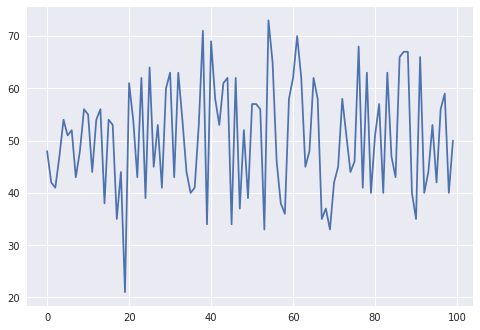

In [48]:
plt.plot(master.agents[0].ep_rewards)

In [ ]:
agent_rewards_history = rewards_history[0]
print("Finished training! Testing...")
print("Total Episode Reward: %d out of 100" % master.test())

plt.style.use('seaborn')
# plt.plot(np.arange(0, len(rewards_history), 5), rewards_history[::5])
plt.plot(np.arange(len(agent_rewards_history)), agent_rewards_history)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

In [ ]:
n_episodes = 100
rewards = []
for _ in range(n_episodes):
    rewards.append(agent.test())
    
print('Average reward from trained agent', np.mean(rewards))

In [ ]:
random_agent = Agent(Model, env)

n_episodes = 100
rewards = []
for _ in range(n_episodes):
    rewards.append(random_agent.test())
    
print('Average reward from random agent', np.mean(rewards))